# Load library

In [2]:
# Import Library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

---

# Set Up the Dataset
The Poker Hand Data Set from UCI contains 11 attributes:

10 Input Attributes: Two cards each for 5 players (rank and suit encoded as integers). </br>
1 Output Attribute: Hand ranking (0-9).

In [5]:
# Download the dataset from UCI Poker Hand Data Set.
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data"
columns = [
    "P1_Rank", "P1_Suit", "P2_Rank", "P2_Suit",
    "P3_Rank", "P3_Suit", "P4_Rank", "P4_Suit",
    "P5_Rank", "P5_Suit", "Hand"
]
data = pd.read_csv(url, header=None, names=columns)

# Display first rows
print(data.head())

   P1_Rank  P1_Suit  P2_Rank  P2_Suit  P3_Rank  P3_Suit  P4_Rank  P4_Suit  \
0        1       10        1       11        1       13        1       12   
1        2       11        2       13        2       10        2       12   
2        3       12        3       11        3       13        3       10   
3        4       10        4       11        4        1        4       13   
4        4        1        4       13        4       12        4       11   

   P5_Rank  P5_Suit  Hand  
0        1        1     9  
1        2        1     9  
2        3        1     9  
3        4       12     9  
4        4       10     9  


---

# Check completeness of data
From the output below, the dataset contains 25,010 rows and 11 columns. There are no missing values in the dataset.

In [8]:
data.columns

Index(['P1_Rank', 'P1_Suit', 'P2_Rank', 'P2_Suit', 'P3_Rank', 'P3_Suit',
       'P4_Rank', 'P4_Suit', 'P5_Rank', 'P5_Suit', 'Hand'],
      dtype='object')

In [9]:
data.shape

(25010, 11)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25010 entries, 0 to 25009
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   P1_Rank  25010 non-null  int64
 1   P1_Suit  25010 non-null  int64
 2   P2_Rank  25010 non-null  int64
 3   P2_Suit  25010 non-null  int64
 4   P3_Rank  25010 non-null  int64
 5   P3_Suit  25010 non-null  int64
 6   P4_Rank  25010 non-null  int64
 7   P4_Suit  25010 non-null  int64
 8   P5_Rank  25010 non-null  int64
 9   P5_Suit  25010 non-null  int64
 10  Hand     25010 non-null  int64
dtypes: int64(11)
memory usage: 2.1 MB


In [11]:
data.isnull().sum()

P1_Rank    0
P1_Suit    0
P2_Rank    0
P2_Suit    0
P3_Rank    0
P3_Suit    0
P4_Rank    0
P4_Suit    0
P5_Rank    0
P5_Suit    0
Hand       0
dtype: int64

---

# Set rules of Texas Hold'em

In Texas Hold'em, decisions depend on hole cards (2 cards) and community cards (up to 5 cards). 
Since the dataset reflects hand rankings for 5-card hands, we need to focus on individual player hands (P1_Rank, P1_Suit, etc.).

**Create scenarios for:**
- Pre-flop (2 cards only).
- Post-flop, turn, and river (adding community cards).
- Encode target strategies (Fold, Call, Raise and Bluff/Not Bluff).

In [15]:
# Select player 1's cards as initial features
# Select relevant columns for player 1's hand and the hand classification
data_prep = data[["P1_Rank", "P1_Suit", "P2_Rank", "P2_Suit", "Hand"]].copy()

# Rename columns to not confuse
data_prep.columns = ["Card1_Rank", "Card1_Suit", "Card2_Rank", "Card2_Suit", "Hand"]

In [27]:
# Add bluff condition (simplistic logic: bluff if hand type is "No Pair")
data_prep.loc[:, "Bluff"] = (data_prep["Hand"] == 0).astype(int)

# Initialize an empty column for strategy
data_prep.loc[:, "Strategy"] = "Fold"  # Default strategy is to fold

# Apply raise logic for strong hands (Hand >= 10, Royal Flush)
data_prep.loc[data_prep["Hand"] >= 10, "Strategy"] = "Raise"

# Apply call logic for moderate hands (Pairs or suited cards)
data_prep.loc[(data_prep["Hand"] >= 5) & (data_prep["Hand"] < 10), "Strategy"] = "Call"

# Apply raise logic for pairs (if both cards are the same rank)
data_prep.loc[data_prep["Card1_Rank"] == data_prep["Card2_Rank"], "Strategy"] = "Raise"

# Apply raise logic for suited cards (if both cards are the same suit)
data_prep.loc[data_prep["Card1_Suit"] == data_prep["Card2_Suit"], "Strategy"] = "Raise"

# Apply bluffing logic: Bluff if hand type is "No Pair" (Hand == 0)
data_prep.loc[data_prep["Bluff"] == 1, "Strategy"] = "Bluff"

# Apply call strategy for suited connectors (e.g., 4-5 of same suit)
data_prep.loc[data_prep["Card1_Rank"] == data_prep["Card2_Rank"] - 1, "Strategy"] = "Call"

In [29]:
# Check 
data_prep.head()

,Card1_Rank,Card1_Suit,Card2_Rank,Card2_Suit,Hand,Bluff,Strategy
0,1,10,1,11,9,0,Raise
1,2,11,2,13,9,0,Raise
2,3,12,3,11,9,0,Raise
3,4,10,4,11,9,0,Raise
4,4,1,4,13,9,0,Raise


---

# EDA

### General information

In [43]:
data_prep.shape

(25010, 7)

In [45]:
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25010 entries, 0 to 25009
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Card1_Rank  25010 non-null  int64 
 1   Card1_Suit  25010 non-null  int64 
 2   Card2_Rank  25010 non-null  int64 
 3   Card2_Suit  25010 non-null  int64 
 4   Hand        25010 non-null  int64 
 5   Bluff       25010 non-null  int64 
 6   Strategy    25010 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [47]:
data_prep.isnull().sum()

Card1_Rank    0
Card1_Suit    0
Card2_Rank    0
Card2_Suit    0
Hand          0
Bluff         0
Strategy      0
dtype: int64

In [49]:
data_prep.describe()

,Card1_Rank,Card1_Suit,Card2_Rank,Card2_Suit,Hand,Bluff
count,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.00000
mean,2.508756,6.995242,2.497721,7.014194,0.621152,0.49952
std,1.116483,3.749805,1.121767,3.766974,0.788361,0.50001
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.00000
25%,2.000000,4.000000,1.000000,4.000000,0.000000,0.00000
50%,3.000000,7.000000,2.000000,7.000000,1.000000,0.00000
75%,4.000000,10.000000,4.000000,10.000000,1.000000,1.00000
max,4.000000,13.000000,4.000000,13.000000,9.000000,1.00000


### Let's see the distirbution

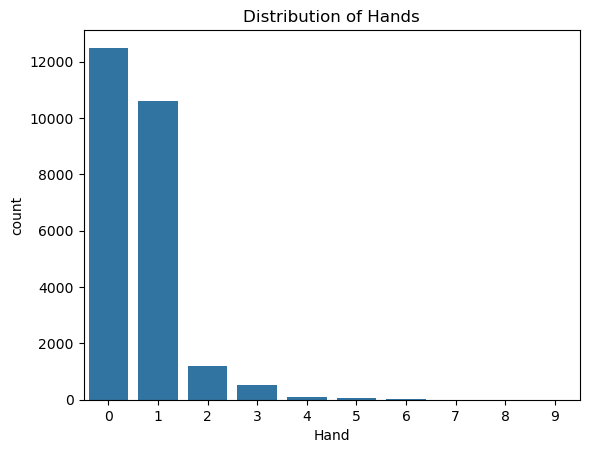

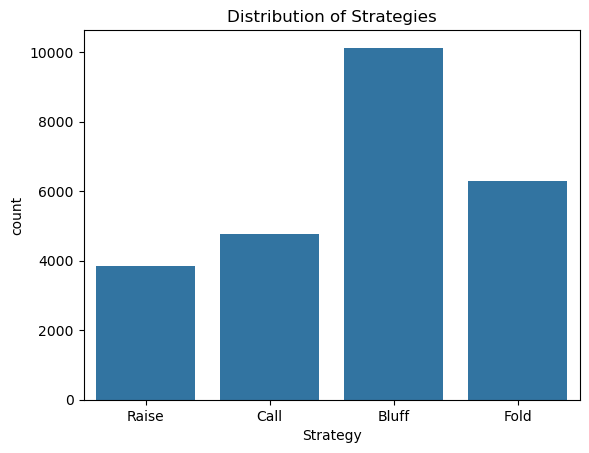

In [52]:
# Distribution of "Hand"
sns.countplot(x="Hand", data=data_prep)
plt.title('Distribution of Hands')
plt.show()

# Distribution of "Strategy"
sns.countplot(x="Strategy", data=data_prep)
plt.title('Distribution of Strategies')
plt.show()

#### Note for Poker Hand Explanation
    0: Nothing in hand; not a recognized poker hand 
    1: One pair; one pair of equal ranks within five cards
    2: Two pairs; two pairs of equal ranks within five cards
    3: Three of a kind; three equal ranks within five cards
    4: Straight; five cards, sequentially ranked with no gaps
    5: Flush; five cards with the same suit
    6: Full house; pair + different rank three of a kind
    7: Four of a kind; four equal ranks within five cards
    8: Straight flush; straight + flush
    9: Royal flush; {Ace, King, Queen, Jack, Ten} + flush

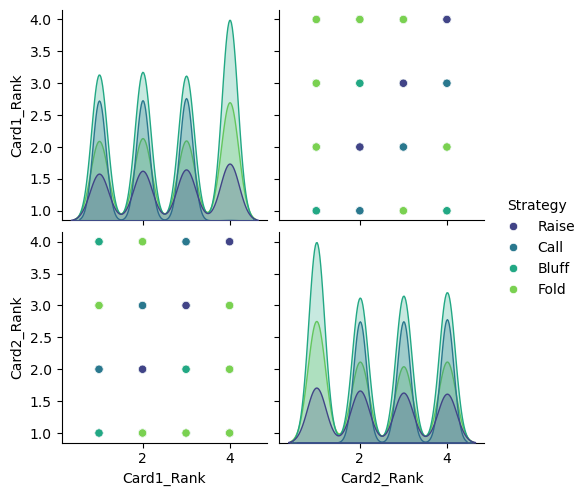

In [70]:
# Strategy by Card Combinations
# To see how card rank and suit combinations influence strategies.
sns.pairplot(data_prep, vars=['Card1_Rank', 'Card2_Rank'], hue='Strategy', palette='viridis')
plt.show()

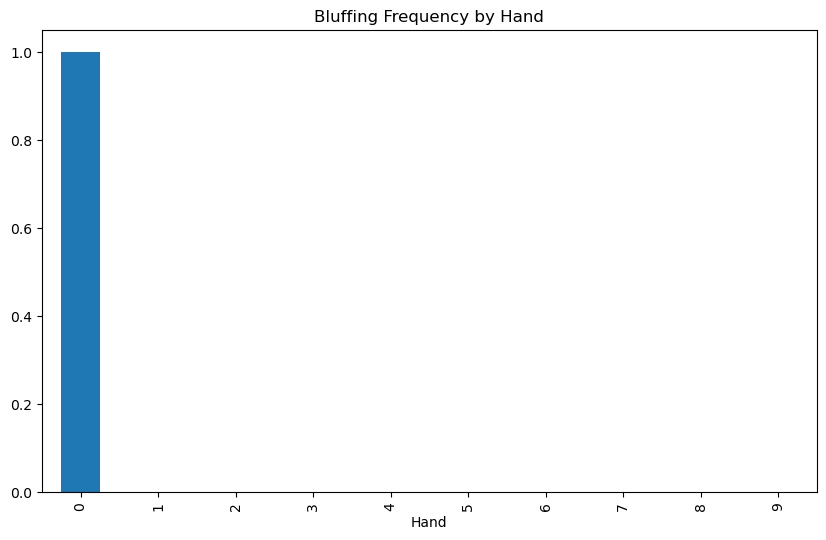

In [76]:
# Check Bluuffing Frequency
bluff_hand = data_prep.groupby('Hand')['Bluff'].mean()
bluff_hand.plot(kind='bar', figsize=(10, 6), title='Bluffing Frequency by Hand')
plt.show()

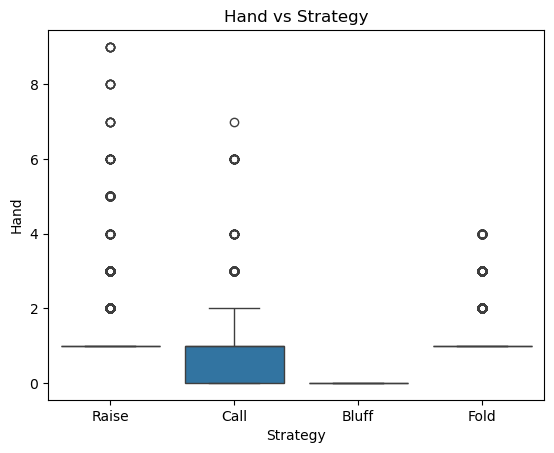

In [55]:
 # View the distribution of hands played according to the "Strategy" type
sns.boxplot(x="Strategy", y="Hand", data=data_prep)
plt.title('Hand vs Strategy')
plt.show()

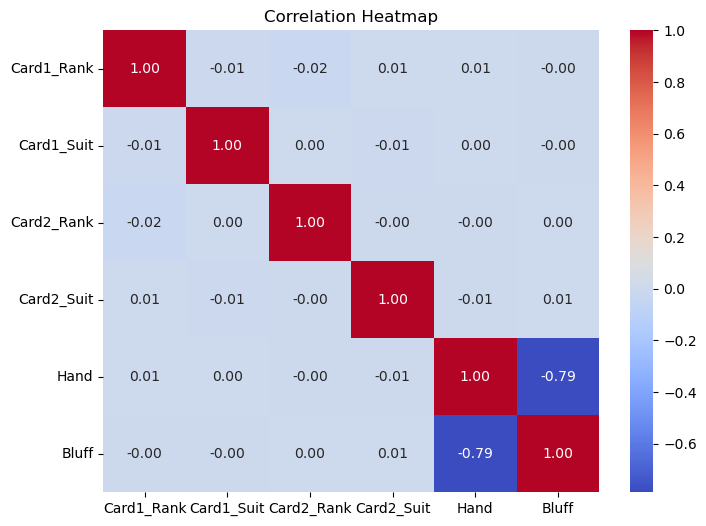

In [57]:
# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(data_prep.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [63]:
data_prep.select_dtypes(include=['number']).corr().round(2)

,Card1_Rank,Card1_Suit,Card2_Rank,Card2_Suit,Hand,Bluff
Card1_Rank,1.00,-0.01,-0.02,0.01,0.01,-0.00
Card1_Suit,-0.01,1.00,0.00,-0.01,0.00,-0.00
Card2_Rank,-0.02,0.00,1.00,-0.00,-0.00,0.00
Card2_Suit,0.01,-0.01,-0.00,1.00,-0.01,0.01
Hand,0.01,0.00,-0.00,-0.01,1.00,-0.79
Bluff,-0.00,-0.00,0.00,0.01,-0.79,1.00


#### Interpret Coefficient

**Card Ranks and Suits**:</br> Very weak correlations with each other and with the hand strength, meaning the rank and suit of the cards don't significantly affect the hand value or strategy.</br></br>
**Bluff**:</br> Strong negative correlation with **Hand** (**-0.79**), indicating that weaker hands are more likely to bluff. Strong positive correlation with **Strategy** (**0.74**), showing bluffing is tied to specific strategies.</br></br>
**Hand and Strategy**:</br> Moderate negative correlation (**-0.55**), suggesting players with stronger hands tend to raise or call, while weaker hands are associated with folding or bluffing.</br></br>

---

In [65]:
# Export data to .csv for further use
data_prep.to_csv('../datasets/data_clean.csv', index=False)